# Google Trends analytics using Python
- Here we will be analyzing the Google search trends on the queries of our intered {You will get a chance to provide input}.

In [6]:
#!pip install pytrends

***Start with importing libraries.***
---
*Probably need to run "pip install pytrends"*

In [7]:
# import necessary libaries
import pandas as pd
import numpy as np

from pytrends.request import TrendReq

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import load_dataset

import warnings
warnings.filterwarnings("ignore")

# Connect to Google
- The first step after installation is to connect Pytrends to Google Trends so that WE can send a request and get the information WE need.
---
The TrendReq receives two important parameters; hl & tz.

hl stands for hosting language for accessing Google Trends; in this example, we set English.

tz stands for timezone

In [8]:
# Configuring connection
trends = TrendReq(hl='en-US', tz= 360, timeout=(10,25))
"""Lets see what we can get with trends object"""
trends

# Build Payload
> The build_payload method from Pytrends is used to build a list of keywords that want to search in Google Trends. Can also specify the timeframe to gather data and the category to query the data from.
---
*kw_list:* list of the target search terms 

*cat:* Category to narrow result fx. Art, Entertainment

*timeframe:* Date to start from fx. Defaults to last 5yrs is 'today 5-y' or Everything is 'all'

*geo:* Location of interest represent by two letter country abbreviation fx. United States is 'US' or Defaults to World

*gprop:* What Google property to filter to fx. "image" or "news" default to web searches

In [9]:
kw_list = [input("Enter the word that wanna see in Google Trends. >> ")]  # list of keywords to get data 
print(f'you have entered {kw_list}')

# Build playload
trends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo= 'NP', gprop='') 

# lets check if we got the data from google or not?
print(f'Trends object is ready to explore as -> {trends}')

Enter the word that wanna see in Google Trends. >> Healthy diet
you have entered ['Healthy diet']
Trends object is ready to explore as -> <pytrends.request.TrendReq object at 0x7f67bc216410>


# What kind of data want to pull? possible methods are:
- Interest Over Time: returns historical, indexed data for when the keyword was searched
- Historical Hourly Interest:  returns historical, indexed, hourly data for when the keyword was searched
- Interest by Region: returns data for where the keyword is most searched
- Related Topics: returns data for the related keywords to a provided keyword
- Related Queries: returns data for the related keywords to a provided keyword
- Trending Searches: returns data for latest trending searches
- Top Charts: returns the data for a given topic
- Suggestions: returns a list of additional suggested keywords that can be used to refine a trend search.

In [10]:
# Function to Disply in the figure
def displayfig(x, y, title, x_label, y_label, fsize):
    """ The function will take x & value including title, x_label & y_label, & figuresize then display the figure"""
    plt.figure(figsize= fsize)
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

***Interest Over Time***

          date  Healthy diet
255 2022-06-26            23
256 2022-07-03            12
257 2022-07-10             6
258 2022-07-17             6
259 2022-07-24             5


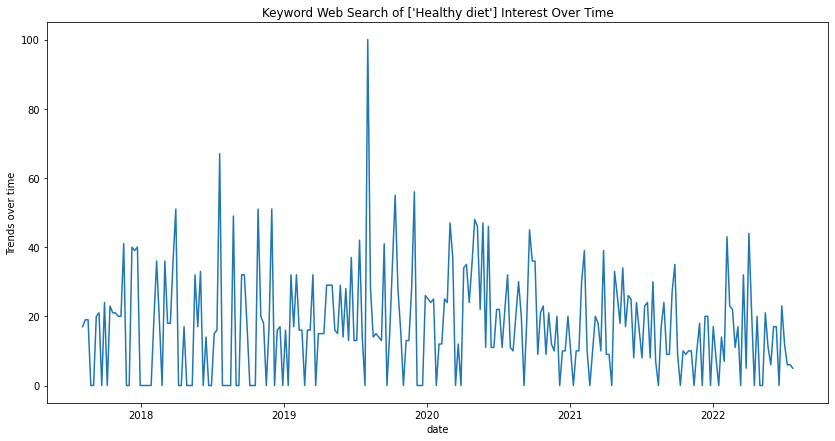

In [11]:
# Interest Over Time
data_over_time= trends.interest_over_time().drop(columns='isPartial')
data_over_time = data_over_time.reset_index()
print(data_over_time.tail())

# Disply in the figure
displayfig(x=data_over_time["date"], y=data_over_time.iloc[:, 1], title= "Keyword Web Search of {kw_list} Interest Over Time".format(kw_list=kw_list), x_label= "date", y_label="Trends over time", fsize= (14, 7))

**Historical Hourly Interest**

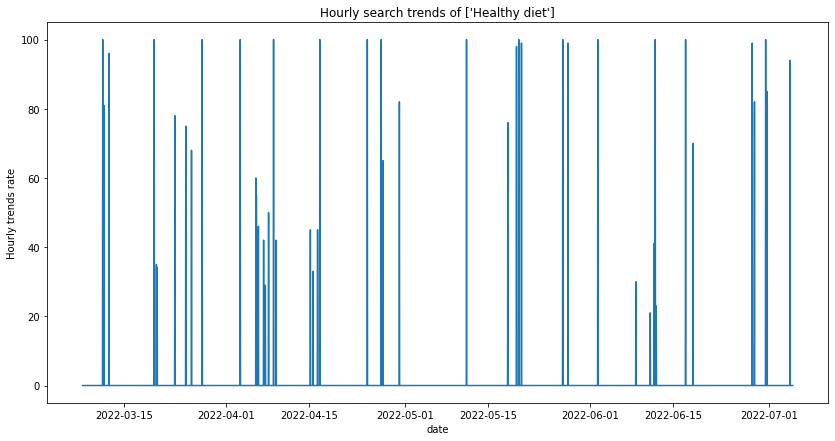

In [12]:
# Historical Hourly Interest (The hourly interest of the keyword)
hourly_trends= trends.get_historical_interest(kw_list, year_start=2022, month_start=3, day_start=1, hour_start=0, year_end=2022, month_end=7, day_end=5, hour_end=0)
hourly_trends = hourly_trends.reset_index()

# Disply in the figure
plt.figure(figsize= (14, 7))
plt.plot(hourly_trends["date"], hourly_trends.iloc[:, 1])
plt.title("Hourly search trends of {kw_list}".format(kw_list=kw_list))
plt.xlabel("date")
plt.ylabel("Hourly trends rate")
plt.show()

**Interest by Region(Search by geographical region)**

To show you which countries search the keyword on a scale of 0 to 100, where 100 represents a country with the most search

*The resolution value is dependent on the geo parameter of the common configuration:*

*Use resolution='COUNTRY' for geo='World'*

*Use resolution='REGION' for geo='US', for example*

In [13]:
# resolution can be either CITY, COUNTRY or REGION
trends_by_region= trends.interest_by_region(resolution='', inc_low_vol=True, inc_geo_code=False)
trends_by_region = trends_by_region.sort_values(by=kw_list, ascending=False)
print(trends_by_region.head(10))


                    Healthy diet
geoName                         
Central Region               100
Eastern Region                 0
Far-Western Region             0
Mid-Western Region             0
Western Region                 0


**Related Queries**

In [14]:
# Related Queries (keywords that are closely tied to a primary keyword of the choice)
related_queries= trends.related_queries()
related_queries[kw_list[0]]['top']

**Trending topics of the year**

In [27]:
# Trending topics of the year
df= pd.DataFrame()

for year in range(2004, 2022):
    trending = trends.top_charts(year, hl= "en-US", geo= "GLOBAL")
    df[year]= trending.title
    
df.iloc[:, :9].head(5)

,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Ferrari,iPod,Aaron Spelling,American Idol,Joe The Plumber,Michael Jackson,iPad,Amazon Kindle Fire,Southwest Airlines
1,BMW,Digital Camera,Kirby Puckett,YouTube,Jeremiah Wright,Transformers,iPhone 4,iPhone 4s,United Airlines
2,Lamborghini,MP3 Player,Jack Wild,Britney Spears,Maverick,Eminem,Nokia 5530,Sidekick 4g,American Airlines
3,Nissan Skyline,iPod Mini,Clifford Geertz,2007 Cricket World Cup,William Ayers,Naruto Shippuden,HTC EVO 4g,Hp Touchpad,Delta Airlines
4,Porsche,PlayStation Portable,Muriel Spark,Chris Benoit,Bridge To Nowhere,Beyoncé,Nokia N900,Spb Shell 3d,Air France


In [28]:
df.iloc[:, 9:].head(5)

,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Oscar Pistorius,Robin Williams,Lamar Odom,Pokémon Go,Hurricane Irma,World Cup,India vs South Africa,Coronavirus,Australia vs India
1,Aaron Hernandez,World Cup,Charlie Hebdo,iPhone 7,iPhone 8,Avicii,Cameron Boyce,Election results,India vs England
2,Adrian Peterson,Ebola,Agar.io,Donald Trump,iPhone X,Mac Miller,Copa America,Kobe Bryant,IPL
3,Kevin Ware,Malaysia Airlines,Jurassic World,Prince,Matt Lauer,Stan Lee,Bangladesh vs India,Zoom,NBA
4,Lance Armstrong,ALS Ice Bucket Challenge,Paris,Powerball,Meghan Markle,Black Panther,iPhone 11,IPL,Euro 2021


***Daily trends***
---
*Daily Search Trends highlights searchers that jumped significantly in traffic among all searches over the past 24 hours and update hourly.*
---
*These trends highlight specific queries that were searched, and an absolute number of searches made*


In [16]:
# Get today´s trending topics
trendingtoday = trends.today_searches(pn='DK')
trendingtoday.head()
  

0    /trends/explore?q=Ayman+al-Zawahiri&date=now+7...
1    /trends/explore?q=Guy+Reffitt&date=now+7-d&geo=DK
2         /trends/explore?q=Serena&date=now+7-d&geo=DK
3    /trends/explore?q=Taylor+Swift&date=now+7-d&ge...
Name: exploreLink, dtype: object

**Realtime Trends Searches in a Specific Country**
---
*It highlight stories that are trending across Google surfaces within the last 24 hours and are updated in real-time*

The "pn" argument specifies the geographical location, the US in our example.

In [17]:
# Get realtime Google Trends data
trends_realtime= trends.trending_searches(pn='denmark')
trends_realtime.head(10)

#df = trends.realtime_trending_searches(pn='denmark')
#df.head(10)

,0
0,Guy Reffitt
1,Serena
2,Taylor Swift
3,Taiwan
4,Su
5,Archie Battersbee
6,Nichelle Nichols
7,Office 365
8,National Girlfriend Day
9,Hugh Hefner
